### Train $P(\text{Label Observed} = 1 \mid X=x)$ Model

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from scipy.sparse import load_npz
from sklearn.metrics import roc_curve, auc, average_precision_score, roc_auc_score, brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import cross_val_predict, StratifiedKFold
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

### Read in feature matrix and labels

In [5]:
data_dir = '/Users/conorcorbin/repos/er_infection/data/ast_models_c/'

X_train = load_npz(os.path.join(data_dir, 'training_examples_round_test.npz'))
df_y_train = pd.read_csv(os.path.join(data_dir, 'training_labels_round_test.csv'))
y_train = df_y_train['label_unobserved']
X_test = load_npz(os.path.join(data_dir, 'test_examples_round_test.npz'))
df_y_test = pd.read_csv(os.path.join(data_dir, 'test_labels_round_test.csv'))
y_test = df_y_test['label_unobserved']

In [6]:
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)
predictions = clf.predict_proba(X_test)[:, 0] # want probability of observing the label

In [7]:
df_y_test['label'] = 1-y_test # so that now label is probability of observing the label
df_y_test['predictions'] = predictions

In [8]:
results_dir = '/Users/conorcorbin/repos/er_infection/data/results/ast_models_c/'
os.makedirs(results_dir, exist_ok=True)
df_y_test.to_csv(os.path.join(results_dir, 'yhats.csv'))

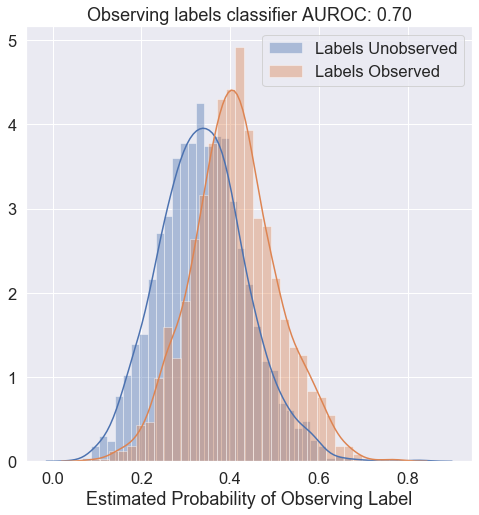

In [26]:
import numpy as np
auc = roc_auc_score(df_y_test['label'], df_y_test['predictions'])
sns.set(font_scale=1.5)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
for label in np.unique(df_y_test['label']): 
    if label == 1:
        lab = "Labels Observed"
    else:
        lab = "Labels Unobserved"
    sns.distplot(df_y_test[df_y_test['label'] == label]['predictions'],
                 label=lab,
                 ax=ax)
ax.set_title("Observing labels classifier AUROC: {:.2f}".format(auc))
ax.set_xlabel("Estimated Probability of Observing Label")
ax.legend()
    

### Calibration Plot

In [51]:
class IdentityEstimator(LogisticRegression):
    def __init__(self):
        LogisticRegression.__init__(self)
            
    def predict_proba(self, input_array):   
        return input_array*1

    def decision_function(self, input_array):
        return input_array*1
    
def calibrate_probabilities(predictions, labels):
    """ 
    Takes in test set probabilites and does a k-fold cross fitting procedure to recalibrate each model
    """
    est = IdentityEstimator()
    X = predictions.values.reshape(-1, 1)
    y = labels
    isotonic_calibrated_predictions = np.array([float(i) for i in range(len(y))])
    sigmoid_calibrated_predictions = np.array([float(i) for i in range(len(y))])

    # Fit base estimator
    est.fit(X, y) # because we've overloaded predict_proba and decision function this doesn't matter

    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv='prefit', method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv='prefit', method='sigmoid')

    cv = StratifiedKFold(n_splits=10)
    for train_inds, val_inds in cv.split(X, y):
        X_train, y_train = X[train_inds], y[train_inds]
        X_val, y_val = X[val_inds], y[val_inds]
        isotonic.fit(X_train, y_train)
        isotonic_predictions = isotonic.predict_proba(X_val)
        isotonic_calibrated_predictions[val_inds] = isotonic_predictions[:, 1]

        sigmoid.fit(X_train, y_train)
        sigmoid_predictions = sigmoid.predict_proba(X_val)
        sigmoid_calibrated_predictions[val_inds] = sigmoid_predictions[:, 1]

    
    return sigmoid_calibrated_predictions, isotonic_calibrated_predictions

def plot_calibration_curves():

    sns.set(font_scale=1.5)
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    prob_pos = df_y_test['predictions']
    labels = df_y_test['label']
    clf_score = brier_score_loss(labels, prob_pos)
    print("\tBrier: %1.3f" % (clf_score))

    fraction_of_positives, mean_predicted_value = \
        calibration_curve(labels, prob_pos, n_bins=10)

    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    ax.plot(mean_predicted_value, fraction_of_positives, "s-",
            label="%s (%1.3f)" % ('Uncalibrated', clf_score))
    
    # Now calibrate
    s_predictions, i_predictions = calibrate_probabilities(prob_pos, labels)
    
    # Sigmoid curve
    clf_score = brier_score_loss(labels, s_predictions)
    print("\t Sigmoid Brier: %1.3f" % (clf_score))
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(labels, s_predictions, n_bins=10)
    ax.plot(mean_predicted_value, fraction_of_positives, "s-",
            label="%s (%1.3f)" % ('Sigmoid', clf_score))
    
    
    # Isotonic curve
    clf_score = brier_score_loss(labels, i_predictions)
    print("\t Isotonic Brier: %1.3f" % (clf_score))
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(labels, i_predictions, n_bins=10)
    ax.plot(mean_predicted_value, fraction_of_positives, "s-",
            label="%s (%1.3f)" % ('Isotonic', clf_score))
    
    ax.legend()
    ax.set_xlabel('Estimated Probability')
    ax.set_ylabel("Fraction of positives")

    

	Brier: 0.211
	 Sigmoid Brier: 0.208
	 Isotonic Brier: 0.208


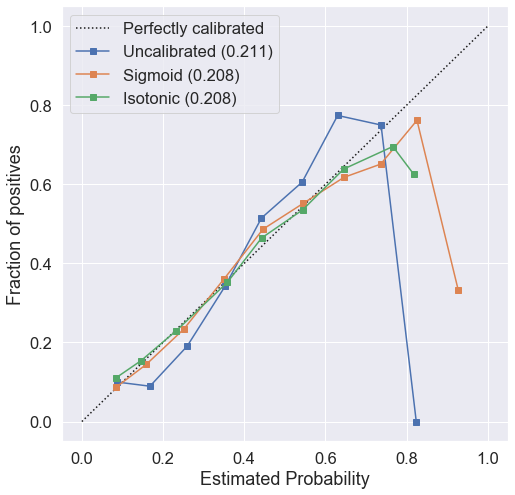

In [52]:
plot_calibration_curves()